In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import random
import numpy as np
import pickle
import xarray as xr
import matplotlib.pyplot as plt
import datetime
import scipy.stats
import pandas as pd
import torch.nn.functional as F
from torchvision import transforms
from torch.optim import lr_scheduler
from   sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
#     torch.backends.cudnn.deterministic = True

setup_seed(906) #906

In [3]:
# 查看设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
nino = np.array([-0.68, -0.43, -0.15,  0.16,  0.48,  0.77,  1.07,  1.32,  1.56, 1.78,  1.92,  1.95]) #2023-2024年能找到到的nino3.4

In [4]:
nino = np.array([-0.68, -0.43, -0.15,  0.16,  0.48,  0.77,  1.07,  1.32,  1.56, 1.78,  1.92,  1.95]) #2023-2024年能找到到的nino3.4

#经度距平，有验证集
class ENSODataset(Dataset):
    """
    type_ : 需要加载的数据类型，分为
        CMIP 加载模式模拟数据
        OBSTrain 加载观测数据
        OBSVal 加载观测验证数据
    T_begin 开始时间
    T_end 结束时间
    其中，后两个参数只适用于 CMIP数据
    """
    def __init__(self, type_, T_begin=None, T_end=None):
        super().__init__()
        self.Type = type_
        if type_ == "OBSTrain1":
            sst = xr.open_dataset(r'Hjingduanosst.nc')
            self.Inisst = sst['__xarray_dataarray_variable__'][:1512,:,:]
            ds0 = xr.open_dataset(r'soda/jingduano(mask)224.nc')
            self.Initemp0 = ds0['temp'][0:1512,0,:,:]
            ds1 = xr.open_dataset(r'soda/jingduano(mask)224.nc')
            self.Initemp1 = ds1['temp'][0:1512,1,:,:]
            ds2 = xr.open_dataset(r'soda/jingduano(mask)224.nc')
            self.Initemp2 = ds2['temp'][0:1512,2,:,:]
            ds3 = xr.open_dataset(r'soda/jingduano(mask)224.nc')
            self.Initemp3 = ds3['temp'][0:1512,3,:,:]
            ds4 = xr.open_dataset(r'soda/jingduano(mask)224.nc')
            self.Initemp4 = ds4['temp'][0:1512,4,:,:]
            ds5 = xr.open_dataset(r'soda/jingduano(mask)224.nc')
            self.Initemp5 = ds5['temp'][0:1512,5,:,:]
            ds6 = xr.open_dataset(r'soda/jingduano(mask)224.nc')
            self.Initemp6 = ds6['temp'][0:1512,6,:,:]
            ds7 = xr.open_dataset(r'soda/jingduano(mask)224.nc')
            self.Initemp7 = ds7['temp'][0:1512,7,:,:]
            ds8 = xr.open_dataset(r'soda/jingduano(mask)224.nc')
            self.Initemp8 = ds8['temp'][0:1512,8,:,:]
            ds9 = xr.open_dataset(r'soda/jingduano(mask)224.nc')
            self.Initemp9 = ds9['temp'][0:1512,9,:,:]
            ds10 = xr.open_dataset(r'soda/jingduano(mask)224.nc')
            self.Initemp10 = ds10['temp'][0:1512,10,:,:]
            ds11 = xr.open_dataset(r'soda/jingduano(mask)224.nc')
            self.Initemp11 = ds11['temp'][0:1512,11,:,:]
            ds12 = xr.open_dataset(r'soda/jingduano(mask)224.nc')
            self.Initemp12 = ds12['temp'][0:1512,12,:,:]
            ds13 = xr.open_dataset(r'soda/jingduano(mask)224.nc')
            self.Initemp13 = ds13['temp'][0:1512,13,:,:]
            ds14 = xr.open_dataset(r'soda/jingduano(mask)224.nc')
            self.Initemp14 = ds14['temp'][0:1512,14,:,:]
            ds15 = xr.open_dataset(r'soda/jingduano(mask)224.nc')
            self.Initemp15 = ds15['temp'][0:1512,15,:,:]
            
            da = pd.read_excel(r'nino34_1871-2022.xlsx')
            da = np.array(da).flatten()
            self.IniNino = da[0:1512]
            self.DataTimeLen = self.IniNino.shape[0]
            
        elif type_ == "OBSTrain2":
            sst = xr.open_dataset(r'Hjingduanosst.nc')
            self.Inisst = sst['__xarray_dataarray_variable__'][1308:1512,:,:]
            ds0 = xr.open_dataset(r'soda/jingduano(mask)3152.nc')
            self.Initemp0 = ds0['temp'][0:204,0,:,:]
            ds1 = xr.open_dataset(r'soda/jingduano(mask)3152.nc')
            self.Initemp1 = ds1['temp'][0:204,1,:,:]
            ds2 = xr.open_dataset(r'soda/jingduano(mask)3152.nc')
            self.Initemp2 = ds2['temp'][0:204,2,:,:]
            ds3 = xr.open_dataset(r'soda/jingduano(mask)3152.nc')
            self.Initemp3 = ds3['temp'][0:204,3,:,:]
            ds4 = xr.open_dataset(r'soda/jingduano(mask)3152.nc')
            self.Initemp4 = ds4['temp'][0:204,4,:,:]
            ds5 = xr.open_dataset(r'soda/jingduano(mask)3152.nc')
            self.Initemp5 = ds5['temp'][0:204,5,:,:]
            ds6 = xr.open_dataset(r'soda/jingduano(mask)3152.nc')
            self.Initemp6 = ds6['temp'][0:204,6,:,:]
            ds7 = xr.open_dataset(r'soda/jingduano(mask)3152.nc')
            self.Initemp7 = ds7['temp'][0:204,8,:,:]
            ds8 = xr.open_dataset(r'soda/jingduano(mask)3152.nc')
            self.Initemp8 = ds8['temp'][0:204,9,:,:]
            ds9 = xr.open_dataset(r'soda/jingduano(mask)3152.nc')
            self.Initemp9 = ds9['temp'][0:204,10,:,:]
            ds10 = xr.open_dataset(r'soda/jingduano(mask)3152.nc')
            self.Initemp10 = ds10['temp'][0:204,12,:,:]
            ds11 = xr.open_dataset(r'soda/jingduano(mask)3152.nc')
            self.Initemp11 = ds11['temp'][0:204,13,:,:]   
            ds12 = xr.open_dataset(r'soda/jingduano(mask)3152.nc')
            self.Initemp12 = ds12['temp'][0:204,14,:,:]
            ds13 = xr.open_dataset(r'soda/jingduano(mask)3152.nc')
            self.Initemp13 = ds13['temp'][0:204,16,:,:]
            ds14 = xr.open_dataset(r'soda/jingduano(mask)3152.nc')
            self.Initemp14 = ds14['temp'][0:204,17,:,:]
            ds15 = xr.open_dataset(r'soda/jingduano(mask)3152.nc')
            self.Initemp15 = ds15['temp'][0:204,18,:,:]
            
            da = pd.read_excel(r'nino34_1871-2022.xlsx')
            da = np.array(da).flatten()
            self.IniNino = da[1308:1512]
            self.DataTimeLen = self.IniNino.shape[0]

        elif type_ == "OBSval":
            sst = xr.open_dataset(r'Hjingduanosst.nc')
            self.Inisst = sst['__xarray_dataarray_variable__'][1512:1680,:,:]
            ds0 = xr.open_dataset(r'soda/jingduano(mask)3152.nc')
            self.Initemp0 = ds0['temp'][204:372,0,:,:]
            ds1 = xr.open_dataset(r'soda/jingduano(mask)3152.nc')
            self.Initemp1 = ds1['temp'][204:372,1,:,:]
            ds2 = xr.open_dataset(r'soda/jingduano(mask)3152.nc')
            self.Initemp2 = ds2['temp'][204:372,2,:,:]
            ds3 = xr.open_dataset(r'soda/jingduano(mask)3152.nc')
            self.Initemp3 = ds3['temp'][204:372,3,:,:]
            ds4 = xr.open_dataset(r'soda/jingduano(mask)3152.nc')
            self.Initemp4 = ds4['temp'][204:372,4,:,:]
            ds5 = xr.open_dataset(r'soda/jingduano(mask)3152.nc')
            self.Initemp5 = ds5['temp'][204:372,5,:,:]
            ds6 = xr.open_dataset(r'soda/jingduano(mask)3152.nc')
            self.Initemp6 = ds6['temp'][204:372,6,:,:]
            ds7 = xr.open_dataset(r'soda/jingduano(mask)3152.nc')
            self.Initemp7 = ds7['temp'][204:372,8,:,:]
            ds8 = xr.open_dataset(r'soda/jingduano(mask)3152.nc')
            self.Initemp8 = ds8['temp'][204:372,9,:,:]
            ds9 = xr.open_dataset(r'soda/jingduano(mask)3152.nc')
            self.Initemp9 = ds9['temp'][204:372,10,:,:]
            ds10 = xr.open_dataset(r'soda/jingduano(mask)3152.nc')
            self.Initemp10 = ds10['temp'][204:372,12,:,:]
            ds11 = xr.open_dataset(r'soda/jingduano(mask)3152.nc')
            self.Initemp11 = ds11['temp'][204:372,13,:,:]
            ds12 = xr.open_dataset(r'soda/jingduano(mask)3152.nc')
            self.Initemp12 = ds12['temp'][204:372,14,:,:]
            ds13 = xr.open_dataset(r'soda/jingduano(mask)3152.nc')
            self.Initemp13 = ds13['temp'][204:372,16,:,:]
            ds14 = xr.open_dataset(r'soda/jingduano(mask)3152.nc')
            self.Initemp14 = ds14['temp'][204:372,17,:,:]
            ds15 = xr.open_dataset(r'soda/jingduano(mask)3152.nc')
            self.Initemp15 = ds15['temp'][204:372,18,:,:]
            
            da = pd.read_excel(r'nino34_1871-2022.xlsx')
            da = np.array(da).flatten()
            self.IniNino = da[1512:1680]
            self.DataTimeLen = self.IniNino.shape[0]

        elif type_ == "OBStest":
            sst = xr.open_dataset(r'Hjingduanosst.nc')
            self.Inisst = sst['__xarray_dataarray_variable__'][1680:,:,:]
            ds0 = xr.open_dataset(r'soda/jingduano(mask)3152.nc')
            self.Initemp0 = ds0['temp'][372:,0,:,:]
            ds1 = xr.open_dataset(r'soda/jingduano(mask)3152.nc')
            self.Initemp1 = ds1['temp'][372:,1,:,:]
            ds2 = xr.open_dataset(r'soda/jingduano(mask)3152.nc')
            self.Initemp2 = ds2['temp'][372:,2,:,:]
            ds3 = xr.open_dataset(r'soda/jingduano(mask)3152.nc')
            self.Initemp3 = ds3['temp'][372:,3,:,:]
            ds4 = xr.open_dataset(r'soda/jingduano(mask)3152.nc')
            self.Initemp4 = ds4['temp'][372:,4,:,:]
            ds5 = xr.open_dataset(r'soda/jingduano(mask)3152.nc')
            self.Initemp5 = ds5['temp'][372:,5,:,:]
            ds6 = xr.open_dataset(r'soda/jingduano(mask)3152.nc')
            self.Initemp6 = ds6['temp'][372:,6,:,:]
            ds7 = xr.open_dataset(r'soda/jingduano(mask)3152.nc')
            self.Initemp7 = ds7['temp'][372:,8,:,:]
            ds8 = xr.open_dataset(r'soda/jingduano(mask)3152.nc')
            self.Initemp8 = ds8['temp'][372:,9,:,:]
            ds9 = xr.open_dataset(r'soda/jingduano(mask)3152.nc')
            self.Initemp9 = ds9['temp'][372:,10,:,:]
            ds10 = xr.open_dataset(r'soda/jingduano(mask)3152.nc')
            self.Initemp10 = ds10['temp'][372:,12,:,:]
            ds11 = xr.open_dataset(r'soda/jingduano(mask)3152.nc')
            self.Initemp11 = ds11['temp'][372:,13,:,:]
            ds12 = xr.open_dataset(r'soda/jingduano(mask)3152.nc')
            self.Initemp12 = ds12['temp'][372:,14,:,:]
            ds13 = xr.open_dataset(r'soda/jingduano(mask)3152.nc')
            self.Initemp13 = ds13['temp'][372:,16,:,:]
            ds14 = xr.open_dataset(r'soda/jingduano(mask)3152.nc')
            self.Initemp14 = ds14['temp'][372:,17,:,:]
            ds15 = xr.open_dataset(r'soda/jingduano(mask)3152.nc')
            self.Initemp15 = ds15['temp'][372:,18,:,:]
            
            da = pd.read_excel(r'nino34_1871-2022.xlsx')
            da = np.array(da).flatten()
            self.IniNino = np.concatenate([da[1680:],nino], axis=0)
            self.DataTimeLen = self.IniNino.shape[0]            


        else:
            raise ValueError("必须是 OBSTrain1, OBSTrain2, OBSval, OBStest 其中之一")

    def __getitem__(self, index):
        """
        index指一个样本在数据集中的索引
        """
        SST = np.array(self.Inisst[index:index + 8])
        DataX0 = np.array(self.Initemp0[index:index + 8])
        DataX1 = np.array(self.Initemp1[index:index + 8])
        DataX2 = np.array(self.Initemp2[index:index + 8])
        DataX3 = np.array(self.Initemp3[index:index + 8])
        DataX4 = np.array(self.Initemp4[index:index + 8])
        DataX5 = np.array(self.Initemp5[index:index + 8])
        DataX6 = np.array(self.Initemp6[index:index + 8])
        DataX7 = np.array(self.Initemp7[index:index + 8])
        DataX8 = np.array(self.Initemp8[index:index + 8])
        DataX9 = np.array(self.Initemp9[index:index + 8])
        DataX10 = np.array(self.Initemp10[index:index + 8])
        DataX11 = np.array(self.Initemp11[index:index + 8])
        DataX12 = np.array(self.Initemp12[index:index + 8])
        DataX13 = np.array(self.Initemp13[index:index + 8])
        DataX14 = np.array(self.Initemp14[index:index + 8])
        DataX15 = np.array(self.Initemp15[index:index + 8])
        DataX = np.concatenate([SST, DataX0, DataX1, DataX2, DataX3, DataX4, DataX5, DataX6, DataX7, DataX8, DataX9, DataX10, DataX11, DataX12, DataX13, DataX14, DataX15], axis=0)  #, DataX12, DataX13, DataX14, DataX15
        # DataX = np.concatenate([DataX15, DataX14, DataX13, DataX12, DataX11, DataX10, DataX9, DataX8, DataX7, DataX6, DataX5, DataX4, DataX3, DataX2, DataX1, DataX0], axis=0)
        DataX = torch.tensor(DataX, dtype=torch.float32)
        
        DataY = np.array(self.IniNino[index + 8:index + 8 + 19])
        DataY = torch.tensor(DataY, dtype=torch.float32)
        return DataX, DataY

    def __len__(self):
        return int(self.DataTimeLen - 8 - 19 + 1)

In [5]:
# CBAM结合了通道注意力和空间注意力，分别关注"什么"特征重要和"哪里"重要
 
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super().__init__()
        self.avg_pool=nn.AdaptiveAvgPool2d(1)
        self.max_pool=nn.AdaptiveMaxPool2d(1)
        self.fc1=nn.Conv2d(in_planes, in_planes//ratio, 1, bias=False)
        self.relu1=nn.ReLU()
        self.fc2=nn.Conv2d(in_planes//ratio, in_planes, 1, bias=False)
        self.sigmoid=nn.Sigmoid()
 
    def forward(self, x):
        avg_out=self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out=self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out=avg_out+max_out
        return self.sigmoid(out)
 
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv1=nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid=nn.Sigmoid()
 
    def forward(self, x):
        avg_out=torch.mean(x, dim=1, keepdim=True)
        max_out, _=torch.max(x, dim=1, keepdim=True)
        x=torch.cat([avg_out, max_out], dim=1)
        x=self.conv1(x)
        return self.sigmoid(x)
 
class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super().__init__()
        self.ca=ChannelAttention(in_planes, ratio)
        self.sa=SpatialAttention(kernel_size)
 
    def forward(self, x):
        x=x*self.ca(x)
        x=x*self.sa(x)
        return x

In [6]:
class ConvNetwork(nn.Module):
    """
    M_Num , 代表卷积过滤器（convolutional filters）
    N_Num , 代表神经元个数（neurons）
    """
    def __init__(self, M_Num, N_Num, is_se=True):
        self.M = M_Num
        self.N = N_Num
        super().__init__()
        self.is_se = is_se
        self.conv = nn.Sequential(
            nn.Conv2d(136, 64, kernel_size=(4, 8), padding="same"),   #此处的160与通道数相同  64
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.Conv2d(64, 128, kernel_size=(4, 8), padding="same"),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(stride=(2, 2), kernel_size=(2, 2)),
            nn.Conv2d(128, 64, kernel_size=(4, 8), stride=(1, 1), padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),) 
        if self.is_se:
            self.se = CBAM(64) #se_block(64) CBAM
        # self.BasicBlock=BasicBlock(64,64) #
        self.dense = nn.Sequential(
            nn.Linear(76800, 128), #3936, 128  76800 48000
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),  # 缓解过拟合，一定程度上正则化
            nn.Linear(128, 64), #M_Num 128, 64
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(64, 19),)

            
    def forward(self, InData):
        x = self.conv(InData)
        x = self.se(x) * x  
        # x = self.BasicBlock(x) * x #
        x = nn.Flatten()(x) 
        # x = self.dense(x)
        return x

In [6]:
#3se
class ConvNetwork(nn.Module):
    """
    M_Num , 代表卷积过滤器（convolutional filters）
    N_Num , 代表神经元个数（neurons）
    """
    def __init__(self, M_Num, N_Num, is_se=True):
        self.M = M_Num
        self.N = N_Num
        super().__init__()
        self.is_se = is_se
        self.conv1 = nn.Sequential(
            nn.Conv2d(136, 64, kernel_size=(4, 8), padding="same"),   #此处的160与通道数相同  64
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),)
        self.se1 = CBAM(64) #se_block(64) CBAM
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(4, 8), padding="same"),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(stride=(2, 2), kernel_size=(2, 2)),)
        self.se2 = CBAM(128) #se_block(64) CBAM
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=(4, 8), stride=(1, 1), padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),) 
        self.se3 = CBAM(64) #se_block(64) CBAM
        # self.BasicBlock=BasicBlock(64,64) #
        self.dense = nn.Sequential(
            nn.Linear(76800, 128), #3936, 128  76800 48000
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),  # 缓解过拟合，一定程度上正则化
            nn.Linear(128, 64), #M_Num 128, 64
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(64, 18),)

            
    def forward(self, InData):
        x = self.conv1(InData)
        # x = self.se1(x) * x 
        x = self.conv2(x)
        x = self.se2(x) * x 
        x = self.conv3(x)
        x = self.se3(x) * x 
        # x = self.BasicBlock(x) * x #
        x = nn.Flatten()(x) 
        # x = self.dense(x)
        return x

# 定义SE注意力机制的类
class se_block(nn.Module):
    # 初始化, in_channel代表输入特征图的通道数, ratio代表第一个全连接下降通道的倍数
    def __init__(self, in_channel, ratio=4):
        # 继承父类初始化方法
        super(se_block, self).__init__()
        
        # 属性分配
        # 全局平均池化，输出的特征图的宽高=1
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=1)
        # 第一个全连接层将特征图的通道数下降4倍
        self.fc1 = nn.Linear(in_features=in_channel, out_features=in_channel//ratio, bias=False)
        # relu激活
        self.relu = nn.ReLU()
        # 第二个全连接层恢复通道数
        self.fc2 = nn.Linear(in_features=in_channel//ratio, out_features=in_channel, bias=False)
        # sigmoid激活函数，将权值归一化到0-1
        self.sigmoid = nn.Sigmoid()
        
    # 前向传播
    def forward(self, inputs):  # inputs 代表输入特征图
    
        # 获取输入特征图的shape
        b, c, h, w = inputs.shape
        # 全局平均池化 [b,c,h,w]==>[b,c,1,1]
        x = self.avg_pool(inputs)
        # 维度调整 [b,c,1,1]==>[b,c]
        x = x.view([b,c])
        
        # 第一个全连接下降通道 [b,c]==>[b,c//4]
        x = self.fc1(x)
        x = self.relu(x)
        # 第二个全连接上升通道 [b,c//4]==>[b,c]
        x = self.fc2(x)
        # 对通道权重归一化处理
        x = self.sigmoid(x)
        
        # 调整维度 [b,c]==>[b,c,1,1]
        x = x.view([b,c,1,1])
        
        # 将输入特征图和通道权重相乘
        outputs = x * inputs
        return outputs

In [7]:
class ConvTransformer(nn.Module):
    def __init__(self, is_se=True, num_classes=19, num_heads=8, num_layers=2):
        super().__init__()
        self.cnn = ConvNetwork(96, 96)
        # 调整维度以适应 Transformer 输入
        self.linear_proj = nn.Linear(76800, 256)
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=256, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.cnn(x)
        x = self.linear_proj(x)
        x = x.unsqueeze(1)  # 添加序列长度维度
        x = self.transformer_encoder(x)
        x = x.squeeze(1)
        x = self.fc(x)
        return x

In [8]:
model = ConvTransformer().to(device)

In [9]:
# 改变学习率
def train_model(model, DL, valDataL, criterion, optimizer, num_epochs, patience=3):
    best_acc = 0.0
    # 用于记录验证集准确率没有提升的连续轮数
    no_improvement_count = 0
    # 创建 ReduceLROnPlateau 调度器，当验证集准确率在 2 个 epoch 内没有提升时，学习率乘以 0.1
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=10, factor=0.1)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0
        for batch, (X, y) in enumerate(DL):
            X = X.type(torch.FloatTensor)
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()

            outputs = model(X)
            outputs = outputs.float()
            outputs = outputs.to(device)
            loss = criterion(outputs, y.float())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # 计算准确率
            preds = outputs.argmax(dim=1)  # 取每个样本的最大值索引
            y = y.argmax(dim=1)  # 取每个样本的最大值索引
            correct_preds += torch.sum(preds == y).item()
            total_preds += y.size(0)

        epoch_loss = running_loss / len(DL)
        epoch_acc = correct_preds / total_preds * 100

        # 在验证集上评估
        model.eval()
        val_correct_preds = 0
        val_total_preds = 0
        with torch.no_grad():
            for batch, (X, y) in enumerate(valDataL):
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                preds = outputs.argmax(dim=1)  # 取每个样本的最大值索引
                y = y.argmax(dim=1)  # 取每个样本的最大值索引
                val_correct_preds += torch.sum(preds == y).item()
                val_total_preds += y.size(0)

        val_acc = val_correct_preds / val_total_preds * 100

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%, Val Accuracy: {val_acc:.2f}%")

        # 保存最好的模型
        if val_acc > best_acc:
            best_acc = val_acc
            # 保存模型
            torch.save(model.state_dict(), "/root/autodl-tmp/model/best_model/cnnbest_model.pth")
            # 重置验证集准确率未提升的计数器
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        # 调用调度器更新学习率
        scheduler.step(val_acc)

        # # 检查是否达到早停条件
        # if no_improvement_count >= patience:
        #     print(f"早停：验证集准确率在 {patience} 个 epoch 内没有提升。")
        #     break

    print(f"训练完成。验证集最高准确率为: {best_acc:.2f}%")

In [10]:
class Loss(nn.Module):
    def __init__(self, delta=0.5,scale_mse = 0.2,w_mse_coef = 0.2,quantile1 = 0.86,quantile2 = 0.32): #quantile1 = 0.93,quantile2 = 0.29
        super(Loss, self).__init__()
        self.delta = delta
        self.scale_mse = scale_mse
        self.w_mse_coef = w_mse_coef
        self.quantile1 = quantile1
        self.quantile2 = quantile2
 
    def forward(self, y_true, y_pred):
        diff = torch.abs(y_true - y_pred)
        huberloss = torch.where(diff < self.delta, 0.5 * diff ** 2, self.delta * (diff - 0.5 * self.delta))
        
        w_mse = torch.mean(torch.exp(self.scale_mse * torch.abs(y_true)) * (y_pred - y_true)**2)
        
        residual = y_pred - y_true
        quantileloss = torch.where(y_true > 0.001, torch.max((self.quantile1 - 1) * residual, self.quantile1 * residual), torch.max((self.quantile2 - 1) * residual, self.quantile2 * residual))
        quantileloss1 = torch.max((self.quantile1 - 1) * residual, self.quantile1 * residual)
        quantileloss2 = torch.max((self.quantile2 - 1) * residual, self.quantile2 * residual)

        error = y_true - y_pred
        log_cosh_loss = torch.mean(torch.log(torch.cosh(error))) #torch.mean改成torch.sum

        return torch.mean(quantileloss) #log_cosh_loss #torch.mean(quantileloss) quantileloss1+   huberloss()+  +torch.mean(quantileloss)  #self.w_mse_coef * w_mse
 
# 示例
# delta_value = 0.5
loss_fn = Loss().to(device)

In [11]:
class Loss(nn.Module):
    def __init__(self, delta=0.5,scale_mse = 0.3,w_mse_coef = 0.9,quantile1 = 0.81,quantile2 = 0.31):
        super(Loss, self).__init__()
        self.delta = delta
        self.scale_mse = scale_mse
        self.w_mse_coef = w_mse_coef
        self.quantile1 = quantile1
        self.quantile2 = quantile2
 
    def forward(self, y_true, y_pred):
            
        diff = torch.abs(y_true - y_pred)
        huberloss = torch.where(diff < self.delta, 0.5 * diff ** 2, self.delta * (diff - 0.5 * self.delta))
        
        w_mse = torch.mean(torch.exp(self.scale_mse * torch.abs(y_true)) * (y_pred - y_true)**2)
        
        residual = y_pred - y_true
        quantileloss = torch.where(y_true > -0.501, torch.max((self.quantile1 - 1) * residual, self.quantile1 * residual), torch.max((self.quantile2 - 1) * residual, self.quantile2 * residual))
        quantileloss1 = torch.max((self.quantile1 - 1) * residual, self.quantile1 * residual)
        quantileloss2 = torch.max((self.quantile2 - 1) * residual, self.quantile2 * residual)

        error = y_true - y_pred
        log_cosh_loss = torch.mean(torch.log(torch.cosh(error))) #torch.mean改成torch.sum

        return self.w_mse_coef * w_mse #log_cosh_loss #torch.mean(quantileloss) quantileloss1+   huberloss()+  +torch.mean(quantileloss)  #self.w_mse_coef * w_mse
 
# 示例
# delta_value = 0.5
loss_fn = Loss().to(device)

In [11]:
# loss_fn = nn.MSELoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0.001) #, lr=0.001 , weight_decay=0.001 , weight_decay=0.01 torch.optim.Adam torch.optim.Adamax torch.optim.AdamW torch.optim.NAdam
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) #StepLR(optimizer, step_size=5, gamma=0.1)  optimizer, step_size=20, gamma=0.5

In [12]:
# 加载训练数据（来自224）
DS1 = ENSODataset("OBSTrain1")
# 加载训练数据（来自3152）
DS2 = ENSODataset("OBSTrain2")
# 生成DataLoader（将观测和模拟数据进行合并）
DL = DataLoader(ConcatDataset((DS2, DS1)), batch_size=300, shuffle=True)

valDataL=DataLoader(ENSODataset(type_="OBSval"), batch_size=300, shuffle=True) #ENSODataset(type_="OBStest")

In [13]:
# 训练模型
train_model(model, DL, valDataL, loss_fn, optimizer, num_epochs=30, patience=3)

Epoch 1/30, Loss: 0.2306, Train Accuracy: 4.87%, Val Accuracy: 2.11%
Epoch 2/30, Loss: 0.1968, Train Accuracy: 4.33%, Val Accuracy: 3.52%
Epoch 3/30, Loss: 0.1934, Train Accuracy: 5.23%, Val Accuracy: 4.93%
Epoch 4/30, Loss: 0.1921, Train Accuracy: 4.27%, Val Accuracy: 2.82%
Epoch 5/30, Loss: 0.1916, Train Accuracy: 6.79%, Val Accuracy: 4.93%
Epoch 6/30, Loss: 0.1904, Train Accuracy: 5.59%, Val Accuracy: 2.82%
Epoch 7/30, Loss: 0.1898, Train Accuracy: 4.57%, Val Accuracy: 10.56%
Epoch 8/30, Loss: 0.1894, Train Accuracy: 8.95%, Val Accuracy: 9.15%
Epoch 9/30, Loss: 0.1879, Train Accuracy: 7.21%, Val Accuracy: 14.79%
Epoch 10/30, Loss: 0.1856, Train Accuracy: 7.99%, Val Accuracy: 13.38%
Epoch 11/30, Loss: 0.2024, Train Accuracy: 11.72%, Val Accuracy: 8.45%
Epoch 12/30, Loss: 0.1992, Train Accuracy: 7.93%, Val Accuracy: 16.20%
Epoch 13/30, Loss: 0.1932, Train Accuracy: 12.62%, Val Accuracy: 13.38%
Epoch 14/30, Loss: 0.1953, Train Accuracy: 11.54%, Val Accuracy: 6.34%
Epoch 15/30, Loss: 0.

In [14]:
Data=DataLoader(ENSODataset(type_="OBStest"), batch_size=300, shuffle=False)
model.eval()
with torch.no_grad():
    X,y = next(iter(Data))
    X = X.type(torch.FloatTensor)
    X,y = X.to(device),y.to(device)
    # Compute prediction
    pred = model(X)
    pred = pred.float()
    pred = pred.to(device)
    
ACCList, PList = [], []
for index_month in range(19):
    accsum=0
    for i in range(12):
        acc, p_value = scipy.stats.pearsonr(pred.T.cpu().detach().numpy()[index_month,i:500:12], y.T.cpu().detach().numpy()[index_month,i:500:12]) #计算相关性
        accsum+=acc
    acc=accsum/12
    ACCList.append(acc)
    PList.append(p_value)

ACCList

[np.float32(0.84932894),
 np.float32(0.79597735),
 np.float32(0.7330381),
 np.float32(0.66685265),
 np.float32(0.6564384),
 np.float32(0.60881686),
 np.float32(0.62694126),
 np.float32(0.6092878),
 np.float32(0.61993426),
 np.float32(0.625826),
 np.float32(0.6337572),
 np.float32(0.6222959),
 np.float32(0.59568757),
 np.float32(0.55039835),
 np.float32(0.48974872),
 np.float32(0.43636927),
 np.float32(0.3770769),
 np.float32(0.3568071),
 np.float32(0.32490233)]

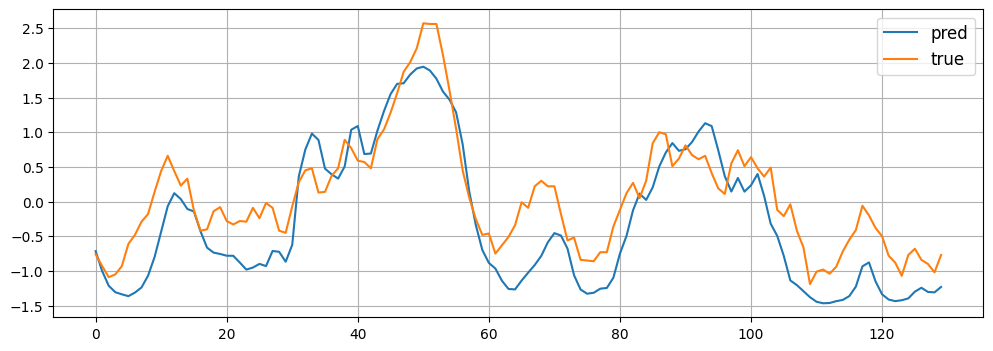

In [15]:
plt.figure(figsize=(12,4))
plt.grid(True)
# plt.title('Nino3.4',size=15)
# plt.xlabel('Forecast lead (months)',fontsize=15)   # x轴显示“日期”，字体大小设置为10
# plt.ylabel('Nino3.4',fontsize=15)
# plt.xticks(time,rotation=90)
# ax.set_xlabel('Forecast lead (months)',fontsize=13)   # x轴显示“日期”，字体大小设置为10
# ax.set_ylabel('Nino3.4',fontsize=13)
plt.plot(pred.T.cpu().detach().numpy()[0],label='pred') #[:,1]
plt.plot(y.T.cpu().detach().numpy()[0],label='true') #[:,1]
plt.legend(loc='best', prop={'size': 12})
# plt.savefig("model/model13/pred和y提前1个月.png", dpi=800) #放在plt.show()之前才能保存下来
plt.show()

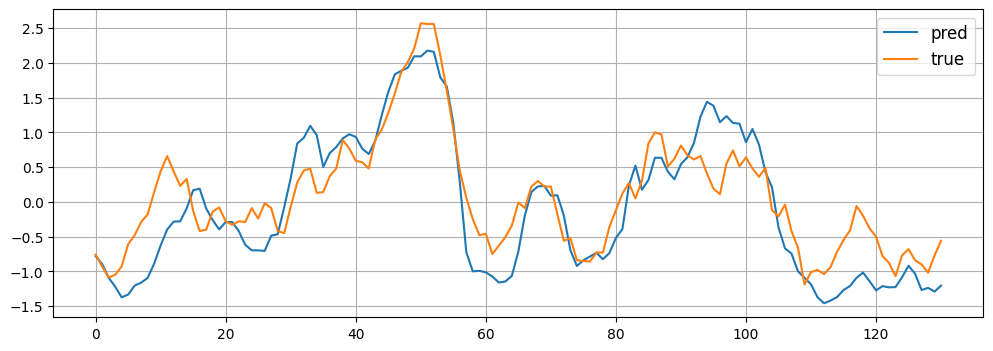

In [15]:
plt.figure(figsize=(12,4))
plt.grid(True)
# plt.title('Nino3.4',size=15)
# plt.xlabel('Forecast lead (months)',fontsize=15)   # x轴显示“日期”，字体大小设置为10
# plt.ylabel('Nino3.4',fontsize=15)
# plt.xticks(time,rotation=90)
# ax.set_xlabel('Forecast lead (months)',fontsize=13)   # x轴显示“日期”，字体大小设置为10
# ax.set_ylabel('Nino3.4',fontsize=13)
plt.plot(pred.T.cpu().detach().numpy()[0],label='pred') #[:,1]
plt.plot(y.T.cpu().detach().numpy()[0],label='true') #[:,1]
plt.legend(loc='best', prop={'size': 12})
# plt.savefig("model/model13/pred和y提前1个月.png", dpi=800) #放在plt.show()之前才能保存下来
plt.show()

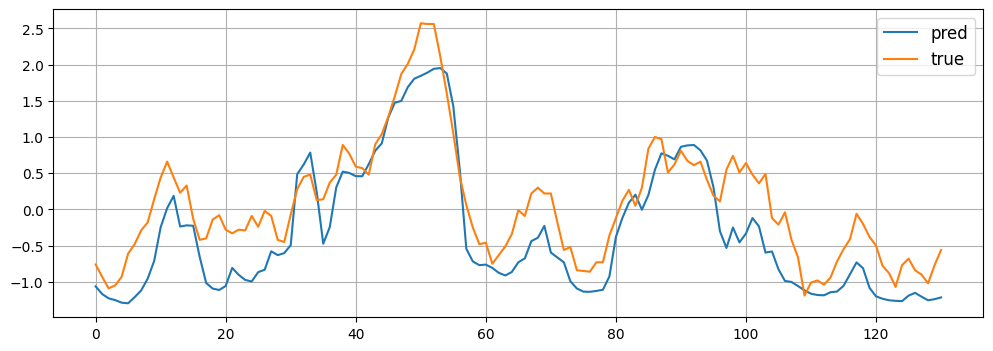

In [15]:
plt.figure(figsize=(12,4))
plt.grid(True)
# plt.title('Nino3.4',size=15)
# plt.xlabel('Forecast lead (months)',fontsize=15)   # x轴显示“日期”，字体大小设置为10
# plt.ylabel('Nino3.4',fontsize=15)
# plt.xticks(time,rotation=90)
# ax.set_xlabel('Forecast lead (months)',fontsize=13)   # x轴显示“日期”，字体大小设置为10
# ax.set_ylabel('Nino3.4',fontsize=13)
plt.plot(pred.T.cpu().detach().numpy()[0],label='pred') #[:,1]
plt.plot(y.T.cpu().detach().numpy()[0],label='true') #[:,1]
plt.legend(loc='best', prop={'size': 12})
# plt.savefig("model/model13/pred和y提前1个月.png", dpi=800) #放在plt.show()之前才能保存下来
plt.show()

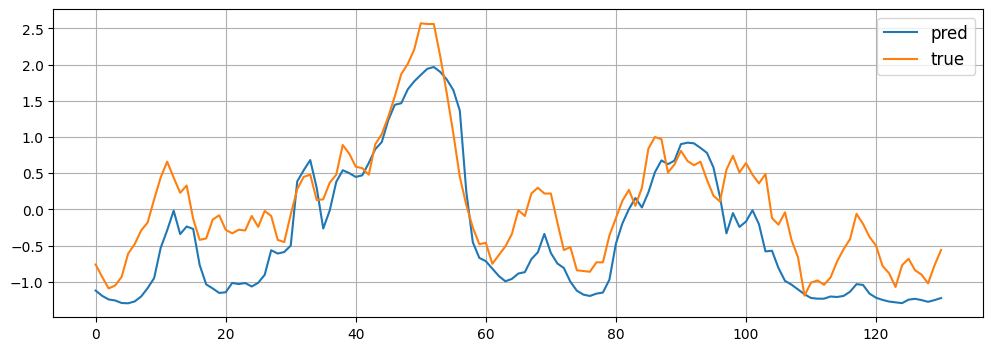

In [15]:
plt.figure(figsize=(12,4))
plt.grid(True)
# plt.title('Nino3.4',size=15)
# plt.xlabel('Forecast lead (months)',fontsize=15)   # x轴显示“日期”，字体大小设置为10
# plt.ylabel('Nino3.4',fontsize=15)
# plt.xticks(time,rotation=90)
# ax.set_xlabel('Forecast lead (months)',fontsize=13)   # x轴显示“日期”，字体大小设置为10
# ax.set_ylabel('Nino3.4',fontsize=13)
plt.plot(pred.T.cpu().detach().numpy()[0],label='pred') #[:,1]
plt.plot(y.T.cpu().detach().numpy()[0],label='true') #[:,1]
plt.legend(loc='best', prop={'size': 12})
# plt.savefig("model/model13/pred和y提前1个月.png", dpi=800) #放在plt.show()之前才能保存下来
plt.show()

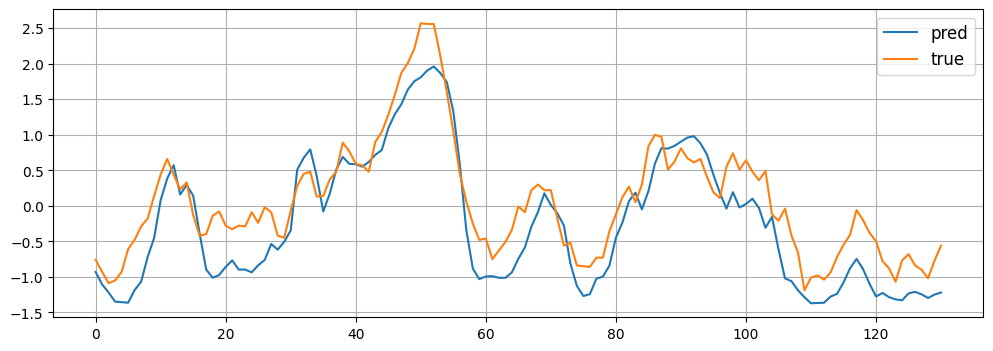

In [15]:
plt.figure(figsize=(12,4))
plt.grid(True)
# plt.title('Nino3.4',size=15)
# plt.xlabel('Forecast lead (months)',fontsize=15)   # x轴显示“日期”，字体大小设置为10
# plt.ylabel('Nino3.4',fontsize=15)
# plt.xticks(time,rotation=90)
# ax.set_xlabel('Forecast lead (months)',fontsize=13)   # x轴显示“日期”，字体大小设置为10
# ax.set_ylabel('Nino3.4',fontsize=13)
plt.plot(pred.T.cpu().detach().numpy()[0],label='pred') #[:,1]
plt.plot(y.T.cpu().detach().numpy()[0],label='true') #[:,1]
plt.legend(loc='best', prop={'size': 12})
# plt.savefig("model/model13/pred和y提前1个月.png", dpi=800) #放在plt.show()之前才能保存下来
plt.show()

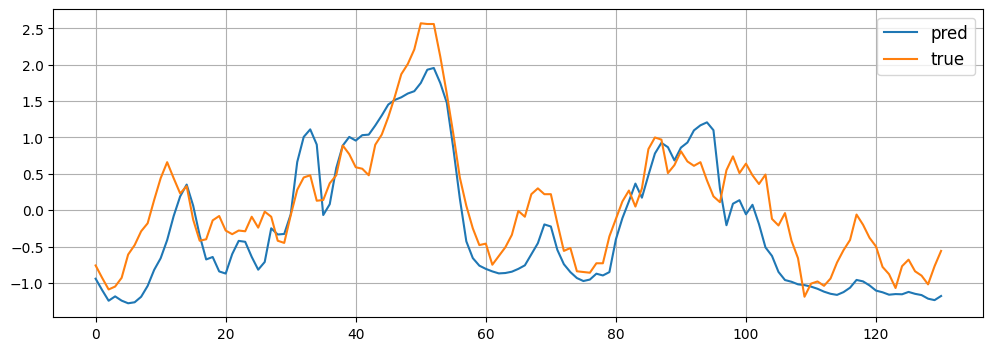

In [15]:
plt.figure(figsize=(12,4))
plt.grid(True)
# plt.title('Nino3.4',size=15)
# plt.xlabel('Forecast lead (months)',fontsize=15)   # x轴显示“日期”，字体大小设置为10
# plt.ylabel('Nino3.4',fontsize=15)
# plt.xticks(time,rotation=90)
# ax.set_xlabel('Forecast lead (months)',fontsize=13)   # x轴显示“日期”，字体大小设置为10
# ax.set_ylabel('Nino3.4',fontsize=13)
plt.plot(pred.T.cpu().detach().numpy()[0],label='pred') #[:,1]
plt.plot(y.T.cpu().detach().numpy()[0],label='true') #[:,1]
plt.legend(loc='best', prop={'size': 12})
# plt.savefig("model/model13/pred和y提前1个月.png", dpi=800) #放在plt.show()之前才能保存下来
plt.show()

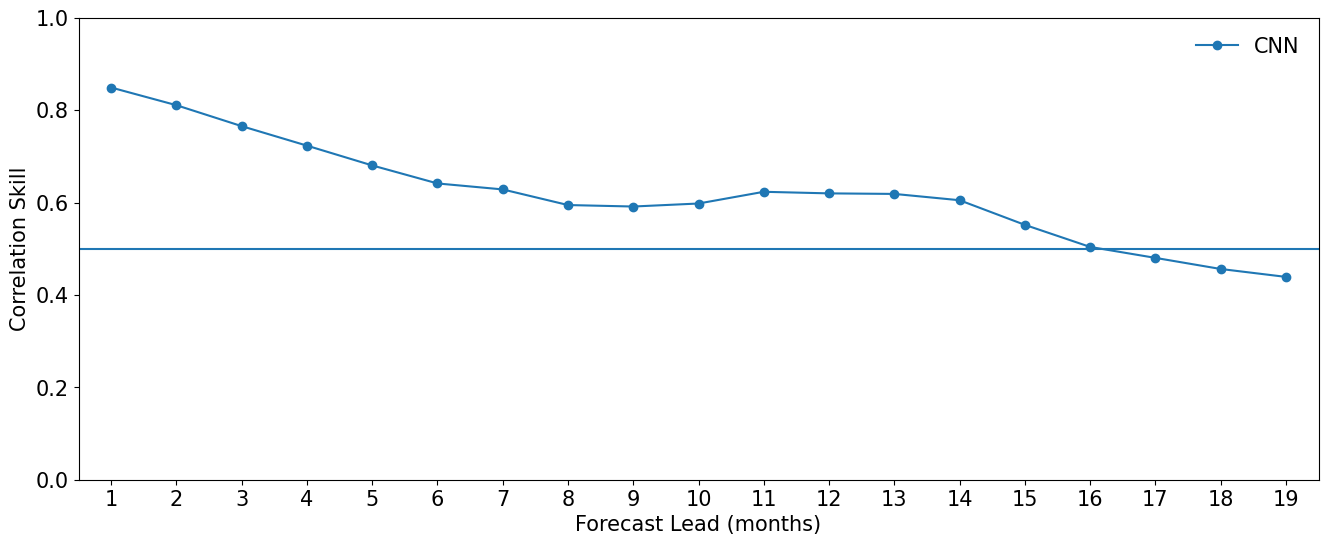

In [16]:
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(111)
ax1.tick_params(labelsize=15)
ax1.plot(np.arange(1, 20), ACCList, "-o", label="CNN") #Dic["ACCList"]
ax1.hlines(0.5, 0.5, 19.5) #0.5, 0.5, 23.5
ax1.set_xlim(0.5, 19.5) #0.5, 23.5
ax1.set_ylim(0, 1)
ax1.set_xlabel("Forecast Lead (months)",fontsize=15)
ax1.set_ylabel("Correlation Skill",fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(np.arange(1, 20, 1))
# plt.savefig("E:\model\model33/pic.png", dpi=800, bbox_inches ='tight') #3semodel2
plt.show()

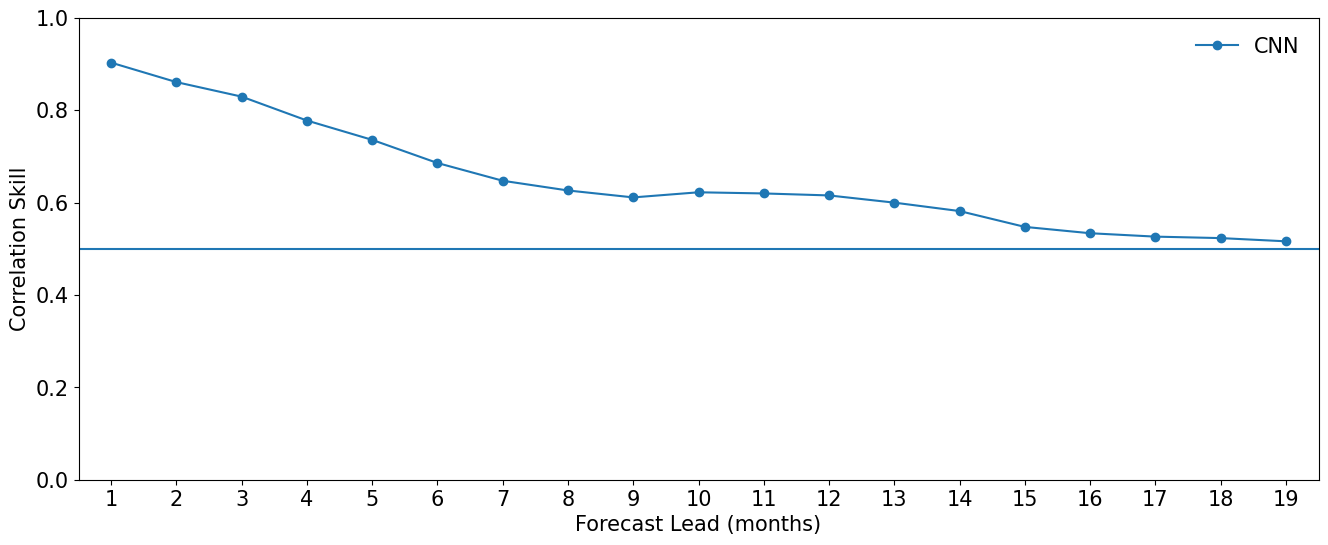

In [16]:
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(111)
ax1.tick_params(labelsize=15)
ax1.plot(np.arange(1, 20), ACCList, "-o", label="CNN") #Dic["ACCList"]
ax1.hlines(0.5, 0.5, 19.5) #0.5, 0.5, 23.5
ax1.set_xlim(0.5, 19.5) #0.5, 23.5
ax1.set_ylim(0, 1)
ax1.set_xlabel("Forecast Lead (months)",fontsize=15)
ax1.set_ylabel("Correlation Skill",fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(np.arange(1, 20, 1))
# plt.savefig("E:\model\model33/pic.png", dpi=800, bbox_inches ='tight') #3semodel2
plt.show()

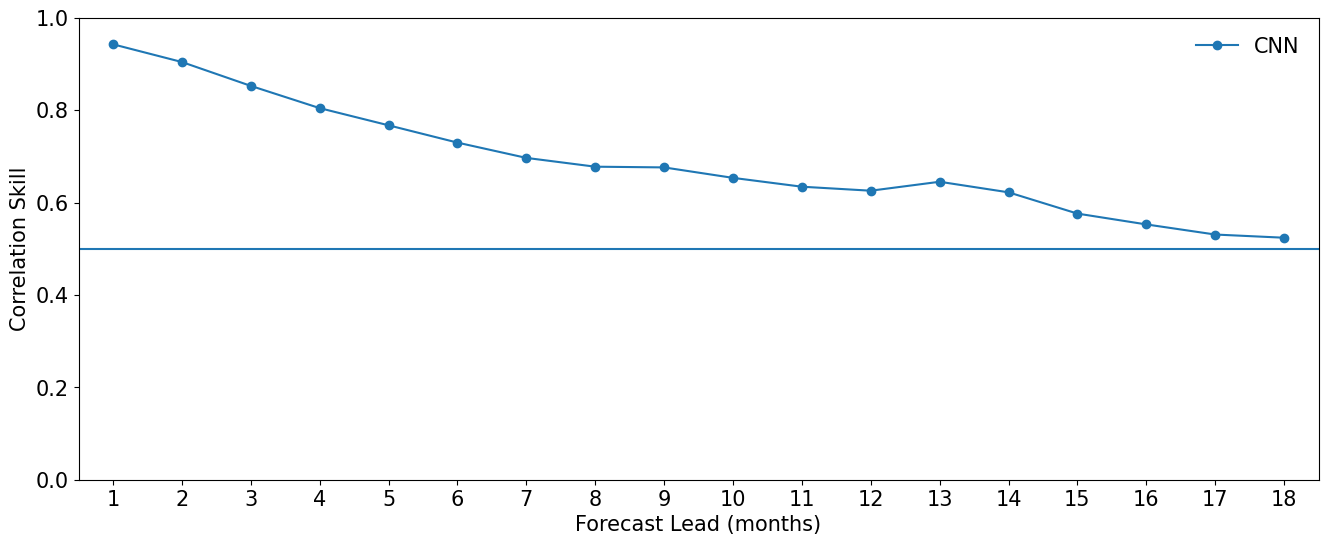

In [16]:
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(111)
ax1.tick_params(labelsize=15)
ax1.plot(np.arange(1, 19), ACCList, "-o", label="CNN") #Dic["ACCList"]
ax1.hlines(0.5, 0.5, 18.5) #0.5, 0.5, 23.5
ax1.set_xlim(0.5, 18.5) #0.5, 23.5
ax1.set_ylim(0, 1)
ax1.set_xlabel("Forecast Lead (months)",fontsize=15)
ax1.set_ylabel("Correlation Skill",fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(np.arange(1, 19, 1))
# plt.savefig("E:\model\model33/pic.png", dpi=800, bbox_inches ='tight') #3semodel2
plt.show()

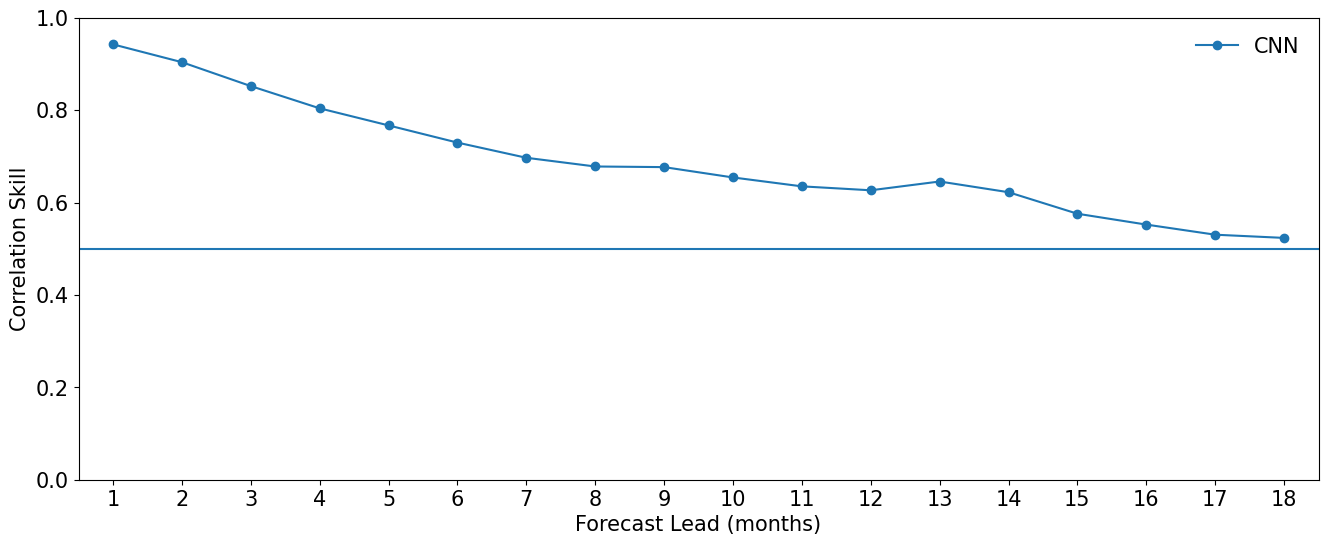

In [16]:
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(111)
ax1.tick_params(labelsize=15)
ax1.plot(np.arange(1, 19), ACCList, "-o", label="CNN") #Dic["ACCList"]
ax1.hlines(0.5, 0.5, 18.5) #0.5, 0.5, 23.5
ax1.set_xlim(0.5, 18.5) #0.5, 23.5
ax1.set_ylim(0, 1)
ax1.set_xlabel("Forecast Lead (months)",fontsize=15)
ax1.set_ylabel("Correlation Skill",fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(np.arange(1, 19, 1))
# plt.savefig("E:\model\model33/pic.png", dpi=800, bbox_inches ='tight') #3semodel2
plt.show()

In [17]:
# 保存整个模型
torch.save(model, 'model/ConvTransformer/model8.pth')
print("整个模型已保存！")

# 加载整个模型
# loaded_model = torch.load('E:\model\model3.pth')
# loaded_model.eval()  # 设置模型为评估模式

# print("整个模型已加载，准备进行预测！")


整个模型已保存！


In [23]:
# 保存整个模型
torch.save(model, 'model/3se/model2.pth')
print("整个模型已保存！")

# 加载整个模型
# loaded_model = torch.load('E:\model\model3.pth')
# loaded_model.eval()  # 设置模型为评估模式

# print("整个模型已加载，准备进行预测！")


整个模型已保存！


In [17]:
pred_np = pred.cpu().numpy()

ds = xr.Dataset({'pred': (['batch_size', 'Forecast_lead'], pred_np)})
ds

<xarray.Dataset> Size: 10kB
Dimensions:  (batch_size: 130, Forecast_lead: 19)
Dimensions without coordinates: batch_size, Forecast_lead
Data variables:
    pred     (batch_size, Forecast_lead) float32 10kB -0.5611 -0.3342 ... 1.047

In [18]:
ds.to_netcdf(r'model\ConvTransformer\model8\pred.nc')

In [19]:
y_np = y.cpu().numpy()

d = xr.Dataset({'true': (['batch_size', 'Forecast_lead'], y_np)})
d

<xarray.Dataset> Size: 10kB
Dimensions:  (batch_size: 130, Forecast_lead: 19)
Dimensions without coordinates: batch_size, Forecast_lead
Data variables:
    true     (batch_size, Forecast_lead) float32 10kB -0.76 -0.93 ... 1.92 1.95

In [20]:
d.to_netcdf(r'model\ConvTransformer\model8\true.nc')

In [15]:
# 加载整个模型
loaded_model = torch.load('model/ConvTransformer/model8.pth')
loaded_model.eval()  # 设置模型为评估模式

ConvTransformer(
  (cnn): ConvNetwork(
    (conv): Sequential(
      (0): Conv2d(136, 64, kernel_size=(4, 8), stride=(1, 1), padding=same)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(64, 128, kernel_size=(4, 8), stride=(1, 1), padding=same)
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
      (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(128, 64, kernel_size=(4, 8), stride=(1, 1), padding=same)
      (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU(inplace=True)
    )
    (se): CBAM(
      (ca): ChannelAttention(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (max_pool): AdaptiveMaxPool2d(output_si

In [16]:
Data=DataLoader(ENSODataset(type_="OBStest"), batch_size=380, shuffle=False)
loaded_model.eval()
with torch.no_grad():
    X,y = next(iter(Data))
    X = X.type(torch.FloatTensor)
    X,y = X.to(device),y.to(device)
    # Compute prediction
    pred = loaded_model(X)
    pred = pred.float()
    pred = pred.to(device)
ACCList, PList = [], []
for index_month in range(19):
    accsum=0
    for i in range(12):
        acc, p_value = scipy.stats.pearsonr(pred.T.cpu().detach().numpy()[index_month,i:500:12], y.T.cpu().detach().numpy()[index_month,i:500:12]) #计算相关性
        accsum+=acc
    acc=accsum/12
    ACCList.append(acc)
    PList.append(p_value)

ACCList

[np.float32(0.9027689),
 np.float32(0.8606158),
 np.float32(0.829187),
 np.float32(0.7774639),
 np.float32(0.7355996),
 np.float32(0.68551403),
 np.float32(0.6470931),
 np.float32(0.6260705),
 np.float32(0.6110779),
 np.float32(0.6221499),
 np.float32(0.6196534),
 np.float32(0.6153564),
 np.float32(0.59975535),
 np.float32(0.5815113),
 np.float32(0.5472471),
 np.float32(0.5335289),
 np.float32(0.52618164),
 np.float32(0.5229948),
 np.float32(0.516048)]

In [23]:
Data=DataLoader(ENSODataset(type_="test2"), batch_size=3000, shuffle=False)
loaded_model.eval()
with torch.no_grad():
    X,y = next(iter(Data))
    X = X.type(torch.FloatTensor)
    X,y = X.to(device),y.to(device)
    # Compute prediction
    pred = loaded_model(X)
    pred = pred.float()
    pred = pred.to(device)

In [10]:
ds0 = xr.open_dataset(r'3152/jingduano.nc')
temp0 = ds0['temp'][522:,0,:,:]
ds1 = xr.open_dataset(r'3152/jingduano.nc')
temp1 = ds1['temp'][522:,1,:,:]
ds2 = xr.open_dataset(r'3152/jingduano.nc')
temp2 = ds2['temp'][522:,2,:,:]
ds3 = xr.open_dataset(r'3152/jingduano.nc')
temp3 = ds3['temp'][522:,3,:,:]
ds4 = xr.open_dataset(r'3152/jingduano.nc')
temp4 = ds4['temp'][522:,4,:,:]
ds5 = xr.open_dataset(r'3152/jingduano.nc')
temp5 = ds5['temp'][522:,5,:,:]
ds6 = xr.open_dataset(r'3152/jingduano.nc')
temp6 = ds6['temp'][522:,6,:,:]
ds7 = xr.open_dataset(r'3152/jingduano.nc')
temp7 = ds7['temp'][522:,8,:,:]
ds8 = xr.open_dataset(r'3152/jingduano.nc')
temp8 = ds8['temp'][522:,9,:,:]
ds9 = xr.open_dataset(r'3152/jingduano.nc')
temp9 = ds9['temp'][522:,10,:,:]
ds10 = xr.open_dataset(r'3152/jingduano.nc')
temp10 = ds10['temp'][522:,12,:,:]
ds11 = xr.open_dataset(r'3152/jingduano.nc')
temp11 = ds11['temp'][522:,13,:,:]
ds12 = xr.open_dataset(r'3152/jingduano.nc')
temp12 = ds12['temp'][522:,14,:,:]
ds13 = xr.open_dataset(r'3152/jingduano.nc')
temp13 = ds13['temp'][522:,16,:,:]
ds14 = xr.open_dataset(r'3152/jingduano.nc')
temp14 = ds14['temp'][522:,17,:,:]
ds15 = xr.open_dataset(r'3152/jingduano.nc')
temp15 = ds15['temp'][522:,18,:,:]

DataX0 = np.array(temp0)
DataX1 = np.array(temp1)
DataX2 = np.array(temp2)
DataX3 = np.array(temp3)
DataX4 = np.array(temp4)
DataX5 = np.array(temp5)
DataX6 = np.array(temp6)
DataX7 = np.array(temp7)
DataX8 = np.array(temp8)
DataX9 = np.array(temp9)
DataX10 = np.array(temp10)
DataX11 = np.array(temp11)
DataX12 = np.array(temp12)
DataX13 = np.array(temp13)
DataX14 = np.array(temp14)
DataX15 = np.array(temp15)
DataX = np.concatenate([DataX0, DataX1, DataX2, DataX3, DataX4, DataX5, DataX6, DataX7, DataX8, DataX9, DataX10, DataX11, DataX12, DataX13, DataX14, DataX15], axis=0) 

DataX = np.expand_dims(DataX,axis=0)
DataX = torch.tensor(DataX, dtype=torch.float32)
DataX = DataX.cuda()

loaded_model.eval()
preds = loaded_model(DataX)

In [11]:
trues = np.array([1.79,  1.49,  1.14,  0.71,  0.39]) #2024年能找到的nino3.4

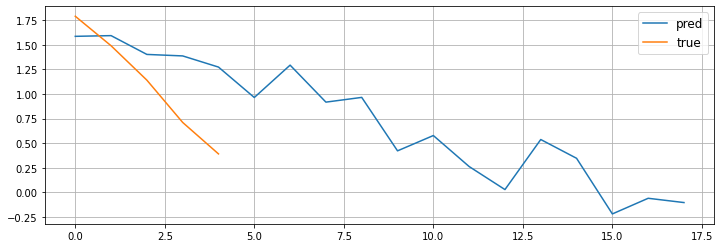

In [12]:
plt.figure(figsize=(12,4))
plt.grid(True)
# plt.title('Nino3.4',size=15)
# plt.xlabel('Forecast lead (months)',fontsize=15)   # x轴显示“日期”，字体大小设置为10
# plt.ylabel('Nino3.4',fontsize=15)
# plt.xticks(time,rotation=90)
plt.plot(preds.cpu().detach().numpy()[0],label='pred') #[:,1]
plt.plot(trues,label='true') #[:,1]
plt.legend(loc='best', prop={'size': 12})
# plt.savefig("model/model13/pred2024.png", dpi=800) #放在plt.show()之前才能保存下来
plt.show()

In [15]:
da = xr.Dataset({'pred': (['batch_size', 'Forecast_lead'], preds.cpu().detach().numpy())})
da

<xarray.Dataset>
Dimensions:  (batch_size: 1, Forecast_lead: 18)
Dimensions without coordinates: batch_size, Forecast_lead
Data variables:
    pred     (batch_size, Forecast_lead) float32 1.586 1.593 ... -0.1049

In [16]:
da.to_netcdf(r'model\model13\2024.nc')